# Daniel Bairamian 260669560 
## ECSE 415 Computer Vision
### Assignment 2 Part Two

In [1]:
# Defining Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def show_images(images, cols , titles):
    
    n_images = len(images)
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.xticks([]), plt.yticks([])
        plt.imshow(image, cmap="gray")
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

## 2. Matching using SIFT - Book Reveal

### Find SIFT Keypoints in given input images 

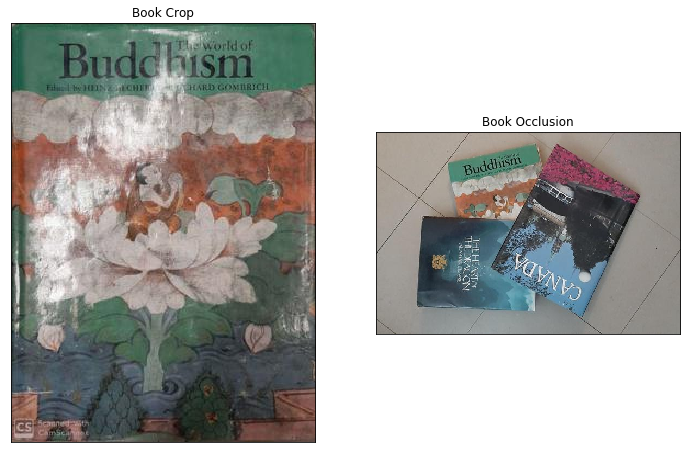

In [3]:
# Load images
book_crop      = cv2.cvtColor(cv2.imread("book_crop.jpg"), cv2.COLOR_BGR2RGB)
book_occlusion = cv2.cvtColor(cv2.imread("book_occlusion.jpg"), cv2.COLOR_BGR2RGB)

titles = ["Book Crop", "Book Occlusion"]
images = [book_crop, book_occlusion]

show_images(images, len(images)/2, titles)

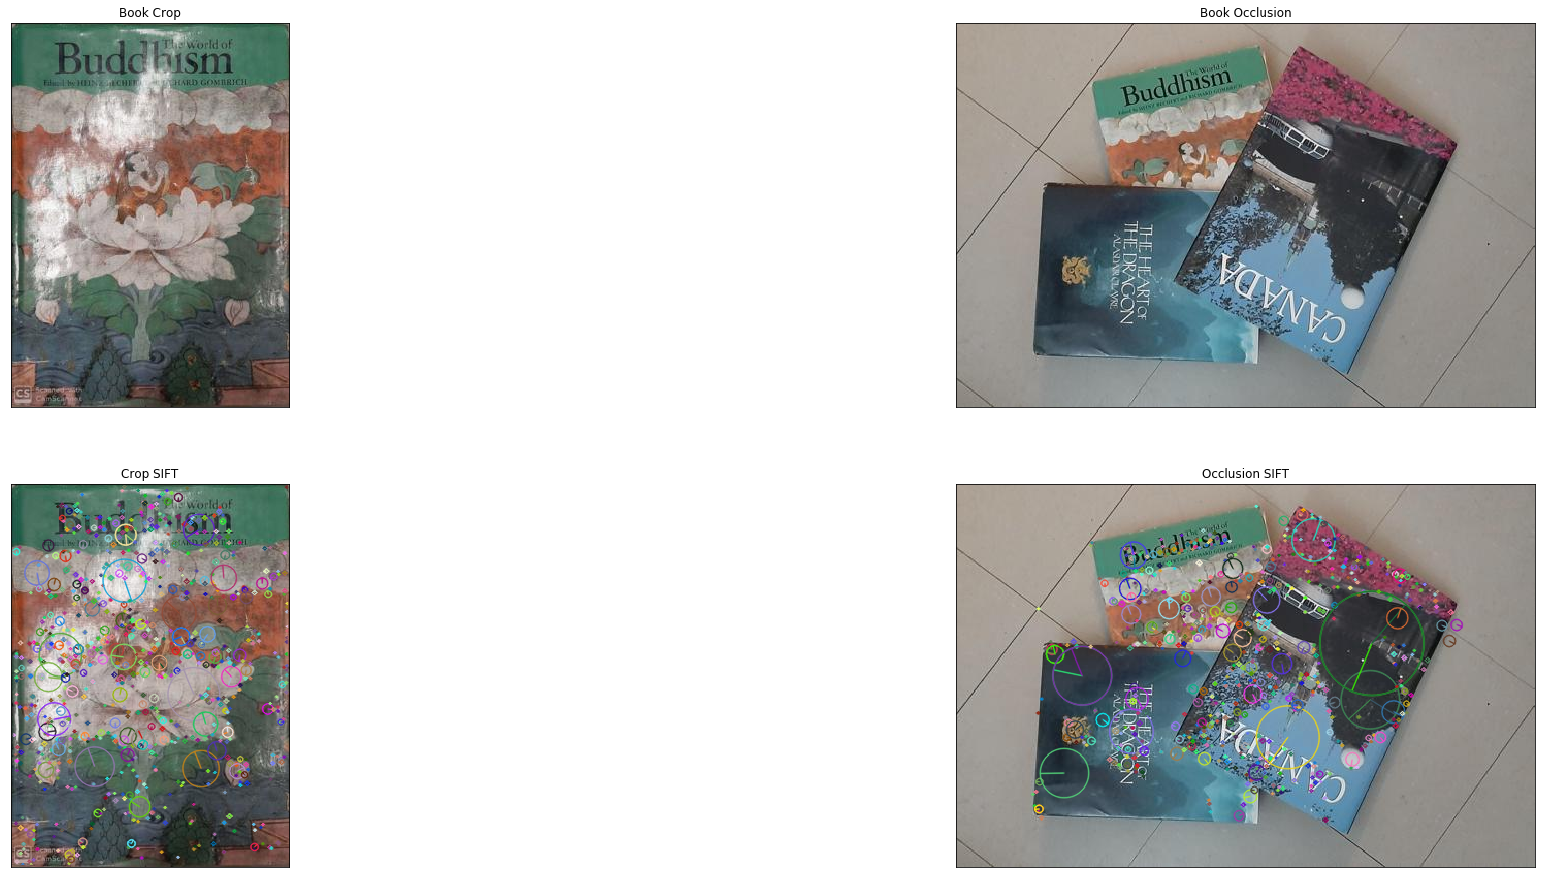

In [4]:
# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# compute SIFT descriptors
crop_key, crop_desc = sift.detectAndCompute(book_crop     , None)
occl_key, occl_desc = sift.detectAndCompute(book_occlusion, None)

sift_crop = book_crop.copy()
sift_occl = book_occlusion.copy()

# draw the keypoints
cv2.drawKeypoints(book_crop     , crop_key, sift_crop, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(book_occlusion, occl_key, sift_occl, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

titles = ["Book Crop", "Book Occlusion", "Crop SIFT", "Occlusion SIFT"]
images = [book_crop, book_occlusion, sift_crop, sift_occl]

images.append(sift_crop)
images.append(sift_occl)

show_images(images, len(images)/2, titles)

### Match keypoints of reference image to the keypoints of the occluded image using brute-force method.
### Sort matching keypoints according to the matching distance
### Display top ten matching keypoints

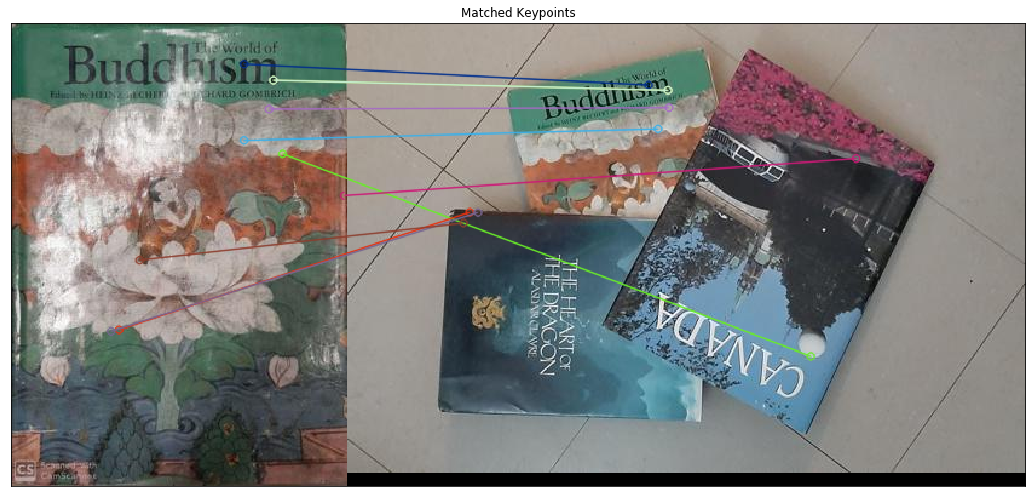

In [5]:
# create BFMatcher object
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

# match descriptors together
match = bf.match(crop_desc,occl_desc)
# sort by distance
match = sorted(match, key = lambda x:x.distance)
# draw image
matching_im = cv2.drawMatches(book_crop, crop_key, book_occlusion,occl_key, match[:10], None, flags=2)

# display
plt.figure(figsize=(40,40))
plt.subplot(121), plt.imshow(matching_im)
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

### Compute a homography to align the images using RANSAC method and apply the transformation on the reference image

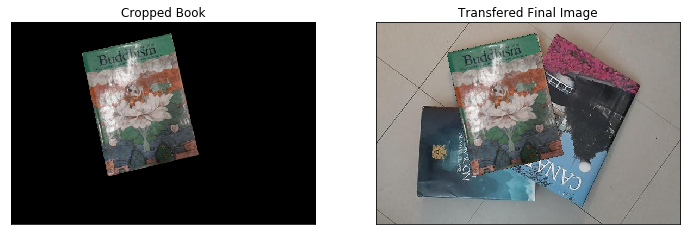

In [6]:
GoodMatches = []

# Tweaked this value to get the desired output
# Found that 300 works good, there might be a better value
# We could find this value with some hyperparameter tuning
# by running a big forloop and just picking which one looks the best
# but this is probably good enough :)

Distance_HYPERPARAM = 300

final_img = book_occlusion.copy()

for i, m in enumerate(match):
    if m.distance < Distance_HYPERPARAM:
        GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([crop_key[i].pt for (__, i) in GoodMatches])
mpl = np.float32([occl_key[i].pt for (i, __) in GoodMatches])

    
# Find homography
H, _ = cv2.findHomography(mpr, mpl, cv2.RANSAC, 4)

# Use homography
height, width, _ = book_occlusion.shape
wimg = cv2.warpPerspective(book_crop, H, (width, height))

wH, wW, wD = wimg.shape

# Apply transformation to reference image
for i in range(wH):
    for j in range(wW):
        for k in range(wD):
            if(wimg[i, j, k] != 0):
                final_img[i,j,k] = wimg[i,j,k]

final_images = [wimg, final_img]
final_titles = ["Cropped Book", "Transfered Final Image"]

show_images(final_images, len(final_images)/2, final_titles)
